# REINFORCEMENT LEARNING: Problem set 3
## Sergio-Yersi Villegas Pelegrín
### *June 2022*
#### **Soft Policy Iteration**

# Modules, functions and parameters

We will begin by importing the relevant modules that we will be using during this third problem set.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from numpy.random import choice

Then, we define the generalized functions that we will be using throughout the exercises, which are briefly described below.

In [15]:
def action(a_type, q_low, q_high):
    
    """
    Given the type of service rate it gets
    as input, returns the corresponding q(a) value.
    
    a_type: type of service rate
    q_low: q value for low service rates
    q_high: q value for high service rates
    
    
    """
    if a_type == 'low':
        return q_low
    else:
        return q_high

def cost(a_type, q_low, q_high):
    """
    Given the type of service rate it gets
    as input, returns the corresponding cost value,
    associated to the action type. It calls the 
    above 'action' function.
    
    a_type: type of service rate
    q_low: q value for low service rates
    q_high: q value for high service rates
    
    """    
    a = action(a_type, q_low, q_high)
    if a == q_low:
        return 0
    else:
        return 0.01

def reward(a_type, q_low, q_high,x,N):
    """
    Given the type of service rate it gets
    as input, returns the corresponding reward value,
    associated to the corresponding action and cost
    which are computed by calling the previous functions,
    for each state x.
    
    a_type: type of service rate
    q_low: q value for low service rates
    q_high: q value for high service rates
    x: state
    N: maximum state (N-1 if starting at 0)
    
    """      
    c = cost(a_type, q_low, q_high)
    return -((x/N)**2)-c

def policy_type(N,pol_type):
    """
    Given the policy type,
    returns a vector with the 
    actions it will perform in 
    each state.
    
    N: maximum state (N-1 if starting at 0)
    pol_type: policy type
    
    """
    policy = np.full(N,'low', dtype='<U16')
    if pol_type == 'agg':
        for i in range(50,N):
            policy[i] = 'high'
    elif pol_type == 'high':
        policy = np.full(N,'high', dtype='<U16')
        
    elif pol_type == 'uniform':
        policy = np.array([choice(a=['low','high'], p=[0.5,0.5]) for i in range(N)])
    return policy   

def feature_map(map_type, x, N):
    
    """
    Given the map type,
    returns a vector with the 
    corresponding feature map
    for the given state x.
    
    map_type: type of feature map
    x: state to compute the map
    N: maximum state (N-1 if starting at 0)
    
    """
        
    if map_type == 'fine':
        return [1 if i==x else 0 for i in range(N)]   
    elif map_type == 'coarse':
        return [1 if (x>=5*(i-1) and x<=5*i-1) else 0 for i in range(1,int(N/5)+1)]   
    else:
        phi1 = [1 if (x>=5*(i-1) and x<=5*i-1) else 0 for i in range(1,int(N/5)+1)]
        phi2 = [(x-5*(i-1))/5 if (x>=5*(i-1) and x<=5*i-1) else 0 for i in range(1,int(N/5)+1)]
        return phi1+phi2

def theta_func(map_type,x,N):
    """
    Given the map type,
    returns a vector of 0s with the 
    length of the corresponding
    feature map for the given state x.
    
    map_type: type of feature map
    x: state to compute the map
    N: maximum state (N-1 if starting at 0)
    
    """
    length = len(feature_map(map_type, x, N))
    return np.zeros((length))

Finally, we define the fixed parameters that are provided in the instructions.

In [27]:
N = 100 # Maximum amount of states
max_iter = 100 # Maximum number of iterations to perform
q_low = 0.51 # q value for low service rate
q_high = 0.6 # q value for high service rate
p = 0.5 # rate at which new requests arrive into the queue
gamma = 0.9 # Discount factor
s0 = 99 # Initial state (full queue)
iter_list = [10000,100000,1000000,10000000] # Sample transitions 
map_list = ['fine','coarse','piecewise'] # Feature maps 


eta_vector = np.logspace(-2,2,num=10) # 10 different etas logspaced (from 0.01 to 100)

In [28]:
eta_vector

array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02])

# Problem: Soft policy iteration

In this last problem set, using the LSTD implementation from the previous problem set, we will implement a soft policy iteration method where the initial policy is set as the uniform policy $π_1(a|x) = \frac{1}{|A|}$ and, at each iteration $k = 1, 2,...,K$, we evaluate the policy with LSTD, compute the Q-function estimates for each action and set the new policy as instructed. We run the algorithm for a range of $M$ values of the learning rate $\eta$ spanning the interval $[0.01,100]$ evenly on a logarithmic scale. For each different $\eta_m$ in the range $m = 1, 2,...,M$, we
record the total amount of reward gathered during learning. Furthermore, we save and use the last state at each iteration of the algorithm (that is, when switching from the last value of $T$ at one $k$ to the next initial value of $T$ at the next $k$, as specified in the instructions). Finally, we add a small numerical constant $\epsilon=1·10^{-100}$ for numerical stability, since Python will set to 0 values that are extremely small and thus, it results into having $\frac{0}{0}$, which is indetermined and yields a NaN, causing an error in the code.

Below, we describe the used method and perform the computations with the chosen parameters: $T=10^5$ sample transitions, $K=100$ iterations and $M=10$ different values of $\eta$. Note that we have reduced the amount of $\eta$ values as instructed, since trying $M=100$ results in a too long computational time.

## Least Squares Temporal Difference

In [33]:
def lstd(s0,N,pol_type,max_iter,a,b,q_low,q_high,map_type,p,gamma,optimal_policy=None):
    """
    Given a policy and an initial state, computes LSTD with the 'expected'
    next state and the corresponding feature maps. When we have looped
    over all the iterations, we compute the inverse matrix using the Moore–
    Penrose pseudoinverse and then the final, updated theta, so we can finally
    create our approximated value function results for each state. We return the
    value functions, the last state of the queue (since we update s0 at each iteration,
    so its last value is the last state of the queue) and the total gathered reward.
    
    s0: initial state
    N: maximum state (N-1 if starting at 0)
    pol_type: policy type
    max_iter: sample transitions
    a: tuning parameter
    b: tuning parameter
    q_low: q value for low service rates
    q_high: q value for high service rates
    map_type: type of feature map
    p: new requests arrival rate
    gamma: discount factor
    optimal policy: using an optimal policy if given (None as default)
    """
    policy = optimal_policy if optimal_policy is not None else policy_type(N, pol_type)
    theta = theta_func(map_type,s0,N)
    states = [i for i in range(N)]
    mat = 0
    b_T = 0
    r_k = 0
    for k in range(1,max_iter):
        alpha = a/(k+b)
        q = action(policy[s0], q_low, q_high)
        if s0==N-1:
            p_dec = (1-p)*q
            p_eq = 1 - (1-p)*q
            s_prime = choice(a=[s0-1,s0], p=[p_dec,p_eq])
        elif s0==0:
            p_inc = p*(1-q)
            p_eq = 1-p*(1-q)
            s_prime = choice(a=[s0+1,s0], p=[p_inc,p_eq])
        else:
            p_dec = (1-p)*q
            p_inc = p*(1-q)
            p_eq = p*q+(1-p)*(1-q)
            s_prime = choice(a=[s0+1,s0-1,s0], p=[p_inc,p_dec,p_eq])
        f_x = np.matrix(feature_map(map_type, s0, N))
        f_next = np.matrix(feature_map(map_type, s_prime, N))
        mat += f_x.T*((f_x-gamma*f_next))
        r_k += reward(policy[s0],q_low,q_high,s0,N)
        b_T += r_k*f_x
        s0 = s_prime
    mat=np.linalg.pinv(mat)
    theta = b_T*mat
    values = [np.dot(theta,feature_map(map_type, i, N)) for i in states]
    return [values, s0, r_k]

## Transition matrix

In [34]:
def transition_matrix(N, pol_type, q_low, q_high, p): 
    """
    Defines the transition matrix with all the corresponding
    queue movement probabilities associated to each state,
    according to a policy type given as input.
    Three cases are identified, each one with specific expressions 
    for the probability of each queue movement:
    empty queue, full queue and all the values in between.
    We define p_dec, p_inc and 
    p_eq as the probabilities of the queue decreasing, increasing and staying equal,
    respectively, as the combined probabilities according to each case.
    
    N: maximum state (N-1 if starting at 0)
    pol_type: policy type
    q_low: q value for low service rates
    q_high: q value for high service rates
    p: new requests arrival rate
    
    """
    transition_mat = np.zeros((N,N))
    policy = policy_type(N, pol_type)
    for x in range(N):
        q = action(policy[x], q_low, q_high)
        if x != 0 and x != N-1: 
            p_dec = (1-p)*q
            p_inc = p*(1-q)
            p_eq = p*q+(1-p)*(1-q)
            transition_mat[x, x] = p_eq
            transition_mat[x,x+1] = p_inc
            transition_mat[x,x-1] = p_dec
        else:
            if x == 0:
                p_dec = 0.0
                p_inc = p*(1-q)
                p_eq = 1-p*(1-q)
                transition_mat[x,x] = p_eq
                transition_mat[x,x+1] = p_inc
            else:
                p_dec = (1-p)*q
                p_inc = 0
                p_eq = 1 - (1-p)*q
                transition_mat[x,x] = p_eq
                transition_mat[x,x-1] = p_dec
    return transition_mat

## Soft policy iteration

In [154]:
def soft_policy_iteration(s0,iterations,a,b,map_type,pol_type,N, initial_pol,\
                     pol_type_low, pol_type_high, q_low, q_high, p, max_iter, gamma, eta,epsilon):
    """
    Iterates over all the states during a maximum number of iterations
    and computes two value functions at each state for the two possible actions. 
    Morever, three cases are identified, each one with specific expressions for 
    the probability of each queue movement:
    empty queue, full queue and all the values in between. At each state,
    if the value function corresponding to the initial action type is
    lower than the other (the one that will update the result), the optimal policy
    is updated accordingly. In other words, if initialized at 'low', if the value
    for 'high' is greater than the one for 'low', it is updated from 'low' to 'high',
    and viceversa if initialized oppositely.

    s0: initial state
    iterations: number of iterations
    a: tuning parameter
    b: tuning parameter    
    map_type: type of feature map    
    pol_type: policy type
    N: maximum state (N-1 if starting at 0)
    initial_pol: policy type to be initialized
    pol_type_low: policy full of low actions
    pol_type_high: policy full of high actions
    q_low: q value for low service rates
    q_high: q value for high service rates
    p: new requests arrival rate
    max_iter: sample transitions
    gamma: discount factor
    eta: learning rate
    epsilon: small constant for numerical stability
    
    """
    optimal_policy = list(policy_type(N,initial_pol))
    low_pol_matrix = transition_matrix(N,pol_type_low,q_low,q_high,p)
    high_pol_matrix = transition_matrix(N,pol_type_high,q_low,q_high,p) 
    old_pi = np.full(N,0.5)
    new_pi = np.zeros(N)
    r_k = 0
  
    for k in range(iterations):
        LSTD_results = lstd(s0,N,pol_type,max_iter,a,b,q_low,\
                                           q_high,map_type,p,gamma,optimal_policy)
            
        policy_value, s0 = LSTD_results[0], LSTD_results[1]
        r_k += LSTD_results[2]
        
        for x in range(N):
            if x==0:
                value_a_low = reward(pol_type_low,q_low,q_high,x,N) + gamma*\
                (low_pol_matrix[x,x+1]*policy_value[x+1] + low_pol_matrix[x,x]*policy_value[x])
                
                value_a_high = reward(pol_type_high,q_low,q_high,x,N) + gamma*\
                (high_pol_matrix[x,x+1]*policy_value[x+1] + high_pol_matrix[x,x]*policy_value[x])        

            elif (x>0) and (x < N - 1):
                value_a_low = reward(pol_type_low,q_low,q_high,x,N) + gamma*\
                (low_pol_matrix[x,x+1]*policy_value[x+1] + low_pol_matrix[x,x]*policy_value[x] + \
                 low_pol_matrix[x,x-1]*policy_value[x-1])
                
                value_a_high = reward(pol_type_high,q_low,q_high,x,N) + gamma*\
                (high_pol_matrix[x,x+1]*policy_value[x+1] + high_pol_matrix[x,x]*policy_value[x] + \
                 high_pol_matrix[x,x-1]*policy_value[x-1])
            else:
                value_a_low = reward(pol_type_low,q_low,q_high,x,N) + gamma*\
                (low_pol_matrix[x,x]*policy_value[x]+low_pol_matrix[x,x-1]*policy_value[x-1])
                value_a_high = reward(pol_type_high,q_low,q_high,x,N) + gamma*\
                (high_pol_matrix[x,x]*policy_value[x] + high_pol_matrix[x,x-1]*policy_value[x-1])

            
            new_pi[x] = (old_pi[x]*np.exp(eta*value_a_low)+epsilon)/(old_pi[x]*np.exp(eta*value_a_low) + \
                                                       (1-old_pi[x])*np.exp(eta*value_a_high) + epsilon) 

            optimal_policy[x] = choice(a=[pol_type_low,pol_type_high], p=[new_pi[x],1-new_pi[x]])
            
        old_pi = new_pi
            
    return [r_k, optimal_policy]


## Results

We will just focus on the gathered rewards for each $\eta$ for the required plots.

In [155]:
rewards_ps3 = []
policies_ps3 = []
for eta in eta_vector:
    res_eta = soft_policy_iteration(s0=s0,iterations=100,a=100000,b=100000,map_type='piecewise',pol_type =None,\
                                      N=N, initial_pol = 'uniform', pol_type_low='low', \
                                      pol_type_high='high',q_low=q_low, q_high=q_high,p=p, \
                                      max_iter=100000, gamma=gamma, eta=eta, epsilon=1e-100)
    rewards_ps3.append(res_eta[0])    
    policies_ps3.append(res_eta[1])

In [169]:
#rewards_ps3 = results_ps3[10:]
rewards_df = pd.DataFrame(rewards_ps3, columns =['rewards'])
rewards_df.to_csv('/Volumes/GoogleDrive/Mi unidad/BSE/TERM 3/RL/data/rewards_ps3.csv')

In [181]:
policies_df = pd.DataFrame(policies_ps3).transpose()
policies_df.columns = ['eta_'+str(i) for i in range(1,11)]
policies_df.to_csv('/Volumes/GoogleDrive/Mi unidad/BSE/TERM 3/RL/data/policies_ps3.csv')

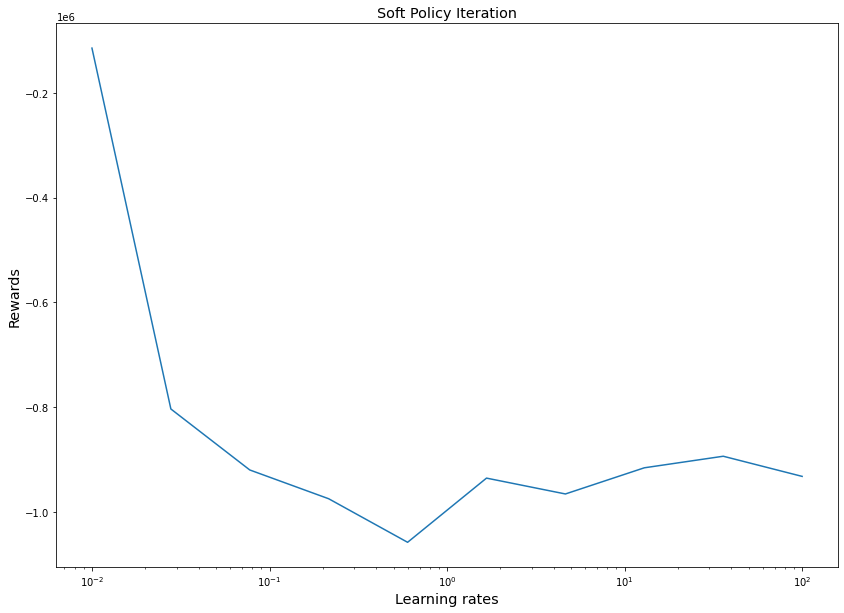

In [182]:
plt.figure(figsize=(14,10))
plt.plot(eta_vector,rewards_ps3)
plt.title('Soft Policy Iteration', fontsize='x-large')
plt.xlabel('Learning rates', fontsize='x-large')
plt.ylabel('Rewards', fontsize='x-large')
plt.xscale('log')
plt.show()

As we can see, there is a decreasing tendency in the gathered rewards with increasing learning rates (which implies more penalization) that are lower than 1, meaning that the reward keeps getting more negative as we increase $\eta$ in that range of values (i.e., $\eta<1$). Then, for learning rates higher than 1, the gathered rewards begin to have a fluctuation behavior, in which they stop decreasing and the results go up and down. With more values of $\eta$, more iterations and more transition samples, this behavior could converge towards having the same gathered rewards after a given value of $\eta$. Therefore, this fluctuation behavior is due to having low values of these iterative parameters; it was not feasible to increase them, since it would take too long to run. Hence, for $\eta$ values greater than 1, it performs well and, more specifically, the performance would reach its best if we used the aforementioned better values of the iterative parameters parameters. Then, learning rates values lower than 1 perform poorly, since they keep improving until they reach $\eta$ values of 1.

All things considered, we can conclude by acknowledging the existence of an optimal learning rate that must be close to and higher than 1, while lower values result in a poor, improvable performance.